In [1]:
from simglucose.simulation.env import T1DSimEnv
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.scenario_gen import RandomScenario
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from datetime import timedelta
from datetime import time as dt_time
from datetime import datetime

import numpy as np
import pandas as pd

In [2]:
# specify start_time as the beginning of today
now = datetime.now()
t0 = datetime.combine(now.date(), dt_time(6, 0, 0, 0))
start_time=t0
#start_time = datetime.combine(now.date(), datetime.min.time())

# --------- Create Random Scenario --------------
# Specify results saving path
path = './results'

df=pd.read_csv('vpatient_params.csv')


In [25]:
from simglucose.simulation.scenario import Action, Scenario
import numpy as np
from scipy.stats import truncnorm
from datetime import datetime
import logging

logger = logging.getLogger(__name__)


class BatchRandomScenario(Scenario):
    def __init__(self, start_time, seed=None):
        Scenario.__init__(self, start_time=start_time)
        self.seed = seed

    def get_action(self, t):
        # t must be datetime.datetime object
        delta_t = t - datetime.combine(t.date(), datetime.min.time())
        t_sec = delta_t.total_seconds()

        if t_sec < 1:
            logger.info('Creating new one day scenario ...')
            self.scenario = self.create_scenario()

        t_min = np.floor(t_sec / 60.0)

        if t_min in self.scenario['meal']['time']:
            logger.info('Time for meal!')
            idx = self.scenario['meal']['time'].index(t_min)
            return Action(meal=self.scenario['meal']['amount'][idx])
        else:
            return Action(meal=0)

    def create_scenario(self):
        scenario = {'meal': {'time': [], 'amount': []}}

        # Probability of taking each meal
        # [breakfast, snack1, lunch, snack2, dinner, snack3]
        prob = [0.95, 0.3, 0.95, 0.3, 0.95, 0.3]
        time_lb = np.array([5, 9, 10, 14, 16, 20]) * 60
        time_ub = np.array([9, 10, 14, 16, 20, 23]) * 60
        time_mu = np.array([7, 9.5, 12, 15, 18, 21.5]) * 60
        time_sigma = np.array([60, 30, 60, 30, 60, 30])
        amount_mu = [10, 3, 20, 3, 20, 3]
        amount_sigma = [3, 1, 3, 1, 3, 1]

        for p, tlb, tub, tbar, tsd, mbar, msd in zip(prob, time_lb, time_ub,
                                                     time_mu, time_sigma,
                                                     amount_mu, amount_sigma):
            if self.random_gen.rand() < p:
                tmeal = np.round(
                    truncnorm.rvs(a=(tlb - tbar) / tsd,
                                  b=(tub - tbar) / tsd,
                                  loc=tbar,
                                  scale=tsd,
                                  random_state=self.random_gen))
                scenario['meal']['time'].append(tmeal)
                scenario['meal']['amount'].append(
                    max(round(self.random_gen.normal(mbar, msd)), 0))

        return scenario

    def reset(self):
        self.random_gen = np.random.RandomState(self.seed)
        self.scenario = self.create_scenario()

    @property
    def seed(self):
        return self._seed

    @seed.setter
    def seed(self, seed):
        self._seed = seed
        self.reset()
        


# SIMULATE A SINGLE PATIENT TO TEST EVERYTHING WORKS

## 1. Setup patient loading its parameters from file
## 2. Setup CGM sensor and pump models
## 3. Setup meal pattern (custom or randomized)
## 4. Simulate the CGM measures

In [4]:
##################################################################################################################
# 1. Setup patient loading its parameters from file
##################################################################################################################
# Create a patient
patient = T1DPatient.withName('adolescent#002')
#add random variation to the Vg value to simulate more patients
patient._params.Vmx=patient._params.Vmx#+0.003*np.random.randn()


In [5]:
##################################################################################################################
# 2. Setup CGM sensor and pump models
##################################################################################################################
# Creat sensor and insulin pump
sensor = CGMSensor.withName('Dexcom', seed=1)
pump = InsulinPump.withName('Insulet')

In [88]:
##################################################################################################################
# 3. Setup custom meal pattern 
# custom scenario is a list of tuples (time, meal_size)
##################################################################################################################
prob = [0.95, 0.3, 0.95, 0.3, 0.95, 0.3]
base_t=[7, 10, 12.5, 16, 20, 22]
base_m = [10, 3, 20, 3, 20, 3]
sigma_m = [2, 1, 3, 1, 3, 1]
#base_t=[7,12,14,18,22]
#base_m=[45,70,15,80,10]
#base_m=[15,20,3,26,3]
scen=[]

for d in range(max_days):
    for i in range(6):
        pmeal=np.random.uniform()
        if(pmeal<prob[i]):
            tm=(base_t[i]+(np.random.uniform()-0.5)*2)*60+d*24*60
            vm=max(0,base_m[i]+sigma_m[i]*np.random.randn())
            scen.append((tm,vm))

#scen = [(7, 45), (12, 70), (16, 15), (18, 80), (23, 10), (7+24, 45), (12+24, 70), (16+24, 15), (18+24, 80), (23+24, 10)]
scenario = CustomScenario(start_time=start_time, scenario=scen)

In [92]:
scenario.scenario

[(370.73221978117573, 9.177268143711435),
 (552.0960299788944, 4.087311052999251),
 (784.6796858993254, 17.396292255081207),
 (1198.9633883666415, 17.223634861477976),
 (1913.9124598439769, 8.867669081291643),
 (2031.666419972641, 3.905006717885363),
 (2187.1875566100543, 13.92509951646313),
 (2388.457940561227, 1.5927736424862498),
 (2681.0591870749813, 22.817983619103597),
 (3247.7038667821435, 11.281211190926888),
 (3652.2683658598557, 20.844137371520464),
 (4076.6231368592134, 19.041074434723974),
 (4788.124835558559, 7.471129364610041),
 (5056.393489708235, 16.04797473850667),
 (5323.853967183884, 2.7258856994027827),
 (5570.313717200114, 16.22533559815612),
 (6123.47619228067, 11.447054813179793),
 (6348.520359900873, 4.892772252387736),
 (6466.689923355887, 19.675406270577195),
 (6999.149639858121, 21.12427552865494),
 (7109.21657716635, 4.008812064977615)]

In [84]:
##################################################################################################################
# 3. Setup custom meal pattern 
# custom scenario is a list of tuples (time, meal_size)
##################################################################################################################
max_days=5

from simglucose.simulation.scenario_gen import RandomScenario
sim_time = timedelta(days=max_days)
now = datetime.now()

#scenario=RandomScenario(start_time=t0, seed=42)
scenario=BatchRandomScenario(start_time=t0, seed=42)
#m = []
#T = []
#
#t = t0
#while t < t0 + sim_time:
#    action = scenario.get_action(t)
#    m.append(action.meal)
#    T.append(t)
#    t += timedelta(minutes=1)

In [79]:
np.array(scenario.scenario['meal']['time'])/60

TypeError: list indices must be integers or slices, not str

Process ID: 8104
Simulation starts ...
Simulation Completed!


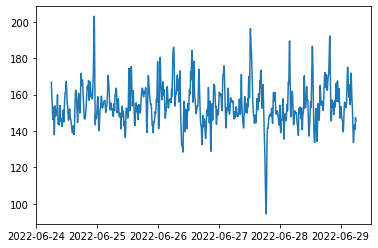

In [86]:
##################################################################################################################
# 4. Simulate the CGM measures
##################################################################################################################

env = T1DSimEnv(patient, sensor, pump, scenario)

# Create a controller
controller = BBController()

# Put them together to create a simulation object
s2 = SimObj(env, controller, timedelta(days=max_days), animate=False, path=path)
results2 = sim(s2)

import matplotlib.pyplot as plt
plt.plot(results2.CGM)

In [13]:
results2

,BG,CGM,CHO,insulin,LBGI,HBGI,Risk
Time,,,,,,,
2022-04-25 06:00:00,149.020000,163.455339,0.0,0.013933,0.0,2.755276,2.755276
2022-04-25 06:05:00,149.020000,158.641938,0.0,0.013933,0.0,2.755276,2.755276
2022-04-25 06:10:00,149.020000,156.123802,0.0,0.013933,0.0,2.755276,2.755276
2022-04-25 06:15:00,149.020000,154.244065,0.0,0.013933,0.0,2.755276,2.755276
2022-04-25 06:20:00,149.020000,152.201426,0.0,0.013933,0.0,2.755276,2.755276
...,...,...,...,...,...,...,...
2022-04-30 05:40:00,135.015574,123.318018,0.0,0.013933,0.0,1.157677,1.157677
2022-04-30 05:45:00,135.430070,123.760636,0.0,0.013933,0.0,1.197003,1.197003
2022-04-30 05:50:00,135.834245,126.728472,0.0,0.013933,0.0,1.235866,1.235866


In [19]:
'{:s}_{:02d}'.format(patient.name,11)

'adolescent#001_11'